# Notebook 01: Procesamiento y Limpieza de Datos - F1 Regresión

## Objetivo
Este notebook implementa el pipeline completo de procesamiento de datos para la predicción de tiempos de vuelta en F1. Incluye:
1. Validación de carga de datos
2. Limpieza y análisis exploratorio (EDA)
3. Validación de limpieza
4. Ingeniería de características

## Metodología
Se procesan 4 datasets principales: Lap_Timings, Race_Results, Track_Information y Race_Schedule.
El target es `milliseconds` (tiempo de vuelta en milisegundos).

## 1. Importaciones y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de rutas
BASE_DIR = Path.cwd().parent.parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
BASE_DIR = BASE_DIR / 'F1_ML'
DATA_RAW = BASE_DIR / "data" / "01_raw"
DATA_CLEANED = BASE_DIR / "data" / "cleaned"
REPORTS_DIR = BASE_DIR / "reports"

# Crear directorios si no existen
DATA_CLEANED.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio base: {BASE_DIR}")
print(f"Datos raw: {DATA_RAW}")
print(f"Datos limpios: {DATA_CLEANED}")

Directorio base: /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML
Datos raw: /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/01_raw
Datos limpios: /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned


## 2. Validación de Carga de Datos

Validamos que los archivos existan y que el target sea adecuado para regresión.

In [2]:
# Cargar datasets
lap_timings = pd.read_csv(DATA_RAW / "Lap_Timings.csv")
race_results = pd.read_csv(DATA_RAW / "Race_Results.csv")
track_info = pd.read_csv(DATA_RAW / "Track_Information.csv")
driver_rankings = pd.read_csv(DATA_RAW / "Driver_Rankings.csv")

# Información de datasets
datasets = {
    'Lap_Timings': lap_timings,
    'Race_Results': race_results,
    'Track_Information': track_info,
    'Driver_Rankings': driver_rankings
}

print("Dimensiones de datasets:")
for name, df in datasets.items():
    print(f"  {name}: {df.shape}")

Dimensiones de datasets:
  Lap_Timings: (575029, 6)
  Race_Results: (26519, 18)
  Track_Information: (77, 9)
  Driver_Rankings: (34595, 7)


In [3]:
# Validación del target
target_col = 'milliseconds'

print(f"\nValidación del target '{target_col}':")
print(f"  Tipo de dato: {lap_timings[target_col].dtype}")
print(f"  Valores únicos: {lap_timings[target_col].nunique()}")
print(f"  Valores nulos: {lap_timings[target_col].isnull().sum()} ({lap_timings[target_col].isnull().mean()*100:.2f}%)")
print(f"  Rango: [{lap_timings[target_col].min()}, {lap_timings[target_col].max()}]")
print(f"  Media: {lap_timings[target_col].mean():.2f} ms")

# Criterios de validación
is_continuous = lap_timings[target_col].dtype in ['int64', 'float64']
null_pct = lap_timings[target_col].isnull().mean()
unique_values = lap_timings[target_col].nunique()

print(f"\nCriterios de validación:")
print(f"  Variable continua: {'✓' if is_continuous else '✗'}")
print(f"  Nulos < 10%: {'✓' if null_pct < 0.1 else '✗'}")
print(f"  Valores únicos > 100: {'✓' if unique_values > 100 else '✗'}")

if is_continuous and null_pct < 0.1 and unique_values > 100:
    print("\n✓ Target válido para regresión")
else:
    print("\n✗ Advertencia: El target puede no ser adecuado")


Validación del target 'milliseconds':
  Tipo de dato: int64
  Valores únicos: 75514
  Valores nulos: 0 (0.00%)
  Rango: [55404, 7507547]
  Media: 95809.80 ms

Criterios de validación:
  Variable continua: ✓
  Nulos < 10%: ✓
  Valores únicos > 100: ✓

✓ Target válido para regresión


## 3. Limpieza de Datos y EDA

Unificamos los datasets y realizamos limpieza completa de datos.

In [4]:
# Cargar Race_Schedule si existe
race_schedule_path = DATA_RAW / "Race_Schedule.csv"
if race_schedule_path.exists():
    race_schedule = pd.read_csv(race_schedule_path)
    print(f"Race_Schedule cargado: {race_schedule.shape}")
else:
    race_schedule = None
    print("Race_Schedule no disponible")

# Merge de datasets
df = lap_timings.copy()

# Merge con Race_Results
df = df.merge(race_results, on=['raceId', 'driverId'], how='left', suffixes=('', '_results'))

# Merge con Track_Information
if race_schedule is not None:
    df = df.merge(race_schedule[['raceId', 'circuitId', 'year']], on='raceId', how='left')
    df = df.merge(track_info, on='circuitId', how='left')
else:
    df = df.merge(track_info, on='circuitId', how='left')

print(f"\nDataset unificado: {df.shape}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())

Race_Schedule cargado: (1125, 18)

Dataset unificado: (575029, 32)

Columnas disponibles:
['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds', 'resultId', 'constructorId', 'number', 'grid', 'position_results', 'positionText', 'positionOrder', 'points', 'laps', 'time_results', 'milliseconds_results', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'circuitId', 'year', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt', 'url']


In [5]:
# Eliminación de duplicados
duplicates_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Duplicados eliminados: {duplicates_count}")
print(f"Registros restantes: {len(df)}")

Duplicados eliminados: 0
Registros restantes: 575029


In [6]:
# Análisis de valores nulos antes de limpieza
print("Valores nulos por columna (top 10):")
null_counts = df.isnull().sum().sort_values(ascending=False)
print(null_counts[null_counts > 0].head(10))

plt.figure(figsize=(12, 6))
null_pcts = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
positive_nulls = null_pcts[null_pcts > 0]

if not positive_nulls.empty:
    positive_nulls.plot(kind='bar')
    plt.title('Porcentaje de valores nulos por columna')
    plt.ylabel('Porcentaje (%)')
    plt.xlabel('Columna')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    plt.close()
    print("No se encontraron columnas con valores nulos para graficar.")

Valores nulos por columna (top 10):
Series([], dtype: int64)
No se encontraron columnas con valores nulos para graficar.


In [7]:
# Manejo de valores nulos
# 1. Target: eliminar filas con target nulo
df = df.dropna(subset=[target_col])
print(f"Registros después de eliminar target nulo: {len(df)}")

# 2. Numéricos: imputar con mediana
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(target_col) if target_col in numeric_cols else None

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# 3. Categóricos: imputar con 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)

print(f"\nValores nulos restantes: {df.isnull().sum().sum()}")

Registros después de eliminar target nulo: 575029

Valores nulos restantes: 0


In [8]:
# Detección y eliminación de outliers usando método IQR
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = (df[target_col] < lower_bound) | (df[target_col] > upper_bound)
outliers_count = outliers.sum()

print(f"Outliers detectados: {outliers_count} ({outliers_count/len(df)*100:.2f}%)")
print(f"Rango válido: [{lower_bound:.2f}, {upper_bound:.2f}]")

df_clean = df[~outliers].copy()
print(f"Registros después de eliminar outliers: {len(df_clean)}")

Outliers detectados: 4476 (0.78%)
Rango válido: [21935.00, 161998.00]
Registros después de eliminar outliers: 570553


In [9]:
# Evitar data leakage: eliminar columnas problemáticas
leakage_cols = ['position', 'fastestLap', 'Driver_Rankings']
cols_to_drop = [col for col in leakage_cols if col in df_clean.columns]

if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Columnas eliminadas para evitar data leakage: {cols_to_drop}")

print(f"\nDataset limpio final: {df_clean.shape}")

Columnas eliminadas para evitar data leakage: ['position', 'fastestLap']

Dataset limpio final: (570553, 30)


### Análisis Exploratorio de Datos (EDA)

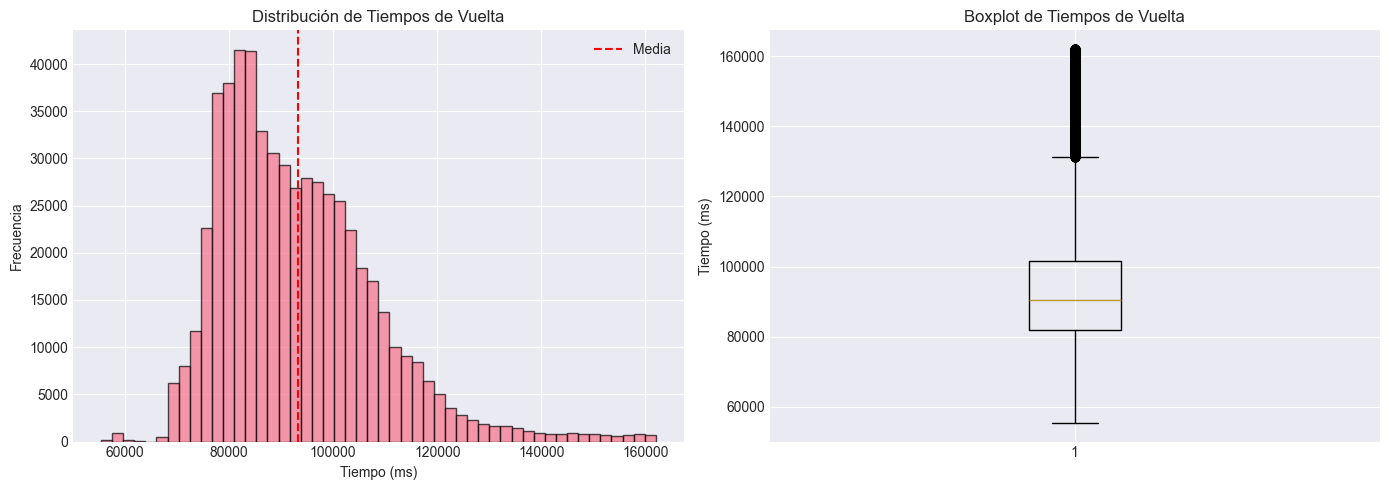

Estadísticas del target:
count    570553.000000
mean      93181.413828
std       15122.019708
min       55404.000000
25%       81904.000000
50%       90469.000000
75%      101681.000000
max      161998.000000
Name: milliseconds, dtype: float64


In [10]:
# EDA: Distribución del target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df_clean[target_col], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Tiempos de Vuelta')
axes[0].set_xlabel('Tiempo (ms)')
axes[0].set_ylabel('Frecuencia')
axes[0].axvline(df_clean[target_col].mean(), color='red', linestyle='--', label='Media')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_clean[target_col])
axes[1].set_title('Boxplot de Tiempos de Vuelta')
axes[1].set_ylabel('Tiempo (ms)')

plt.tight_layout()
plt.show()

print(f"Estadísticas del target:")
print(df_clean[target_col].describe())

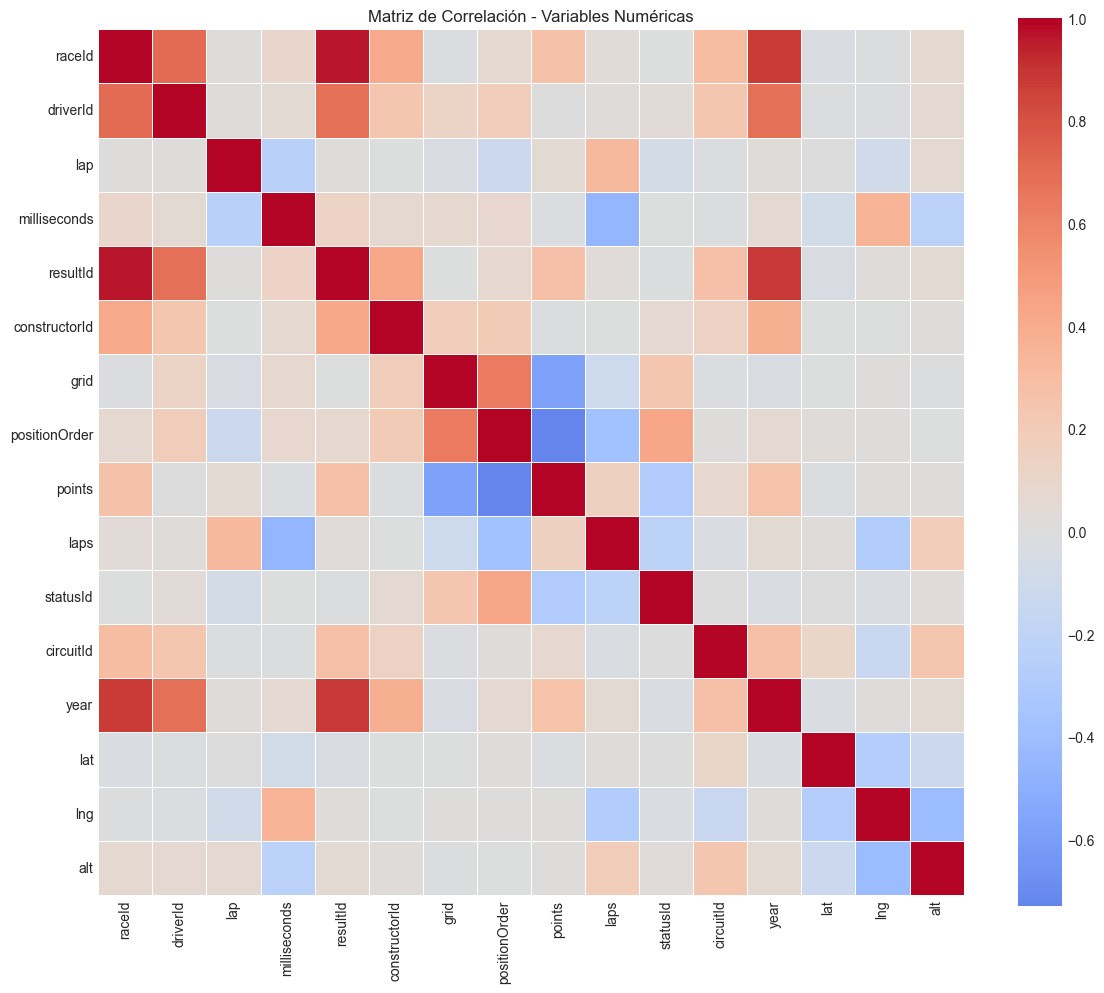


Correlaciones con milliseconds:
milliseconds     1.000000
lng              0.353906
resultId         0.129549
raceId           0.098216
positionOrder    0.085014
grid             0.079958
constructorId    0.063423
year             0.055780
driverId         0.048424
statusId        -0.006199
circuitId       -0.006625
points          -0.014872
lat             -0.075591
alt             -0.228767
lap             -0.248537
laps            -0.453815
Name: milliseconds, dtype: float64


In [11]:
# EDA: Correlaciones iniciales
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_features) > 1:
    correlation_matrix = df_clean[numeric_features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Matriz de Correlación - Variables Numéricas')
    plt.tight_layout()
    plt.show()

    # Correlaciones con el target
    if target_col in correlation_matrix.columns:
        target_corr = correlation_matrix[target_col].sort_values(ascending=False)
        print(f"\nCorrelaciones con {target_col}:")
        print(target_corr)

In [12]:
# Guardar dataset limpio
output_path = DATA_CLEANED / "laptime_cleaned.csv"
df_clean.to_csv(output_path, index=False)
print(f"Dataset limpio guardado en: {output_path}")

Dataset limpio guardado en: /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned/laptime_cleaned.csv


## 4. Validación de Limpieza

Verificamos que los datos limpios cumplan todos los criterios de calidad.

In [13]:
# Cargar datos limpios
df_val = pd.read_csv(DATA_CLEANED / "laptime_cleaned.csv")

print("Validaciones de limpieza:")
print(f"  Archivo existe: ✓")
print(f"  Dimensiones: {df_val.shape}")

# Validación 1: Duplicados
duplicates = df_val.duplicated().sum()
print(f"\n1. Duplicados: {duplicates} {'✓' if duplicates == 0 else '✗'}")

# Validación 2: Nulos críticos
critical_cols = ['milliseconds', 'raceId', 'driverId', 'lap']
available_critical = [col for col in critical_cols if col in df_val.columns]
critical_nulls = df_val[available_critical].isnull().sum().sum()
print(f"2. Nulos críticos en {available_critical}: {critical_nulls} {'✓' if critical_nulls == 0 else '✗'}")

# Validación 3: Distribución del target
cv = df_val[target_col].std() / df_val[target_col].mean()
print(f"3. Coeficiente de variación: {cv:.4f} {'✓' if 0.05 < cv < 1.0 else '✗'}")

# Validación 4: Tipos de datos
numeric_types = df_val.select_dtypes(include=[np.number]).shape[1]
print(f"4. Columnas numéricas: {numeric_types} {'✓' if numeric_types > 0 else '✗'}")

# Validación 5: Rangos razonables
if target_col in df_val.columns:
    time_range_ok = df_val[target_col].between(30000, 300000).all()
    print(f"5. Tiempos en rango razonable (30-300s): {'✓' if time_range_ok else '✗'}")

# Validación 6: Datos suficientes
sufficient_data = len(df_val) > 10000
print(f"6. Registros suficientes (>10,000): {len(df_val)} {'✓' if sufficient_data else '✗'}")

# Validación 7: Valores únicos del target
unique_target = df_val[target_col].nunique()
print(f"7. Valores únicos del target: {unique_target} {'✓' if unique_target > 100 else '✗'}")

Validaciones de limpieza:
  Archivo existe: ✓
  Dimensiones: (570553, 30)

1. Duplicados: 0 ✓
2. Nulos críticos en ['milliseconds', 'raceId', 'driverId', 'lap']: 0 ✓
3. Coeficiente de variación: 0.1623 ✓
4. Columnas numéricas: 17 ✓
5. Tiempos en rango razonable (30-300s): ✓
6. Registros suficientes (>10,000): 570553 ✓
7. Valores únicos del target: 71253 ✓


## 5. Ingeniería de Características

Creamos features derivadas y preparamos los datos para modelado.

In [14]:
# Cargar datos limpios
df_fe = pd.read_csv(DATA_CLEANED / "laptime_cleaned.csv")
print(f"Dataset cargado: {df_fe.shape}")

# Feature 1: lap_group (early/mid/late) - basado en porcentaje de carrera
if 'lap' in df_fe.columns and 'raceId' in df_fe.columns:
    max_lap_per_race = df_fe.groupby('raceId')['lap'].transform('max')
    lap_pct_calc = df_fe['lap'] / max_lap_per_race

    df_fe['lap_group'] = pd.cut(lap_pct_calc,
                                 bins=[0, 0.33, 0.66, 1.0],
                                 labels=['early', 'mid', 'late'])
    print("Feature creada: lap_group (basado en % de carrera)")

# Feature 2: grid_group (pole/top10/backmarker)
if 'grid' in df_fe.columns:
    df_fe['grid_group'] = pd.cut(df_fe['grid'],
                                   bins=[0, 1, 10, 30],
                                   labels=['pole', 'top10', 'backmarker'])
    print("Feature creada: grid_group")

# Feature 3: lap_squared (degradación cuadrática)
if 'lap' in df_fe.columns:
    df_fe['lap_squared'] = df_fe['lap'] ** 2
    print("Feature creada: lap_squared")

# Feature 4: altitude_cat (low/medium/high)
if 'altitude' in df_fe.columns:
    df_fe['altitude_cat'] = pd.cut(df_fe['altitude'],
                                     bins=[-np.inf, 100, 600, np.inf],
                                     labels=['low', 'medium', 'high'])
    print("Feature creada: altitude_cat")

# Feature 5: constructor_circuit_id (interacción equipo-circuito)
if 'constructorId' in df_fe.columns and 'circuitId' in df_fe.columns:
    df_fe['constructor_circuit_id'] = (df_fe['constructorId'].astype(str) + '_' +
                                        df_fe['circuitId'].astype(str))
    print("Feature creada: constructor_circuit_id")

# Feature 6: year_group (eras de F1)
if 'year' in df_fe.columns:
    df_fe['year_group'] = pd.cut(df_fe['year'],
                                   bins=[0, 2013, 2017, 2021, 2030],
                                   labels=['2010-2013', '2014-2017', '2018-2021', '2022+'])
    print("Feature creada: year_group")

# Feature 7: lap_altitude_interaction (dividido por 1000 para escalar)
if 'lap' in df_fe.columns and 'altitude' in df_fe.columns:
    df_fe['lap_altitude_interaction'] = df_fe['lap'] * df_fe['altitude'] / 1000
    print("Feature creada: lap_altitude_interaction")

# Feature 8: lap_pct (porcentaje de carrera completado)
if 'lap' in df_fe.columns and 'raceId' in df_fe.columns:
    # Reutilizar el cálculo anterior si existe
    if 'lap_pct_calc' in locals():
        df_fe['lap_pct'] = lap_pct_calc * 100
    else:
        max_lap_per_race = df_fe.groupby('raceId')['lap'].transform('max')
        df_fe['lap_pct'] = (df_fe['lap'] / max_lap_per_race) * 100
    print("Feature creada: lap_pct")

print(f"\nDataset con features derivadas: {df_fe.shape}")
print(f"Total de features derivadas creadas: 8")

Dataset cargado: (570553, 30)
Feature creada: lap_group (basado en % de carrera)
Feature creada: grid_group
Feature creada: lap_squared
Feature creada: constructor_circuit_id
Feature creada: year_group
Feature creada: lap_pct

Dataset con features derivadas: (570553, 36)
Total de features derivadas creadas: 8


In [15]:
# Codificación de variables categóricas
categorical_features = df_fe.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_fe[col] = le.fit_transform(df_fe[col].astype(str))
    label_encoders[col] = le

print(f"Columnas codificadas: {len(categorical_features)}")
print(categorical_features)

Columnas codificadas: 17
['time', 'position_results', 'positionText', 'time_results', 'milliseconds_results', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'circuitRef', 'name', 'location', 'country', 'url', 'lap_group', 'grid_group', 'constructor_circuit_id', 'year_group']


In [16]:
# Selección de features (evitando data leakage)
# Features candidatos según script 04_feature_engineering.py
feature_candidates = [
    # Información de la vuelta
    'lap', 'lap_pct', 'lap_group', 'lap_squared',

    # Información del piloto
    'driverId',

    # Información del equipo
    'constructorId', 'constructor_circuit_id',

    # Información del circuito
    'circuitId', 'altitude', 'altitude_cat', 'lat', 'lng',

    # Información de la temporada
    'year', 'year_group',

    # Grid position (posición de salida - sin data leakage)
    'grid', 'grid_group',

    # Features derivadas
    'lap_altitude_interaction'
]

# Filtrar features que existen en el dataframe
features = [col for col in feature_candidates if col in df_fe.columns]

print(f"\nFeatures seleccionadas: {len(features)}")
print(features)

# Separar features numéricas y categóricas
numeric_features = df_fe[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_fe[features].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nFeatures numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")


Features seleccionadas: 14
['lap', 'lap_pct', 'lap_group', 'lap_squared', 'driverId', 'constructorId', 'constructor_circuit_id', 'circuitId', 'lat', 'lng', 'year', 'year_group', 'grid', 'grid_group']

Features numéricas: 14
Features categóricas: 0


Correlaciones con el target:
milliseconds              1.000000
lng                       0.353906
grid                      0.079958
constructorId             0.063423
year                      0.055780
driverId                  0.048424
circuitId                -0.006625
year_group               -0.029943
constructor_circuit_id   -0.032074
grid_group               -0.058965
lap_group                -0.059433
lat                      -0.075591
lap_pct                  -0.110191
lap                      -0.248537
lap_squared              -0.255498
Name: milliseconds, dtype: float64


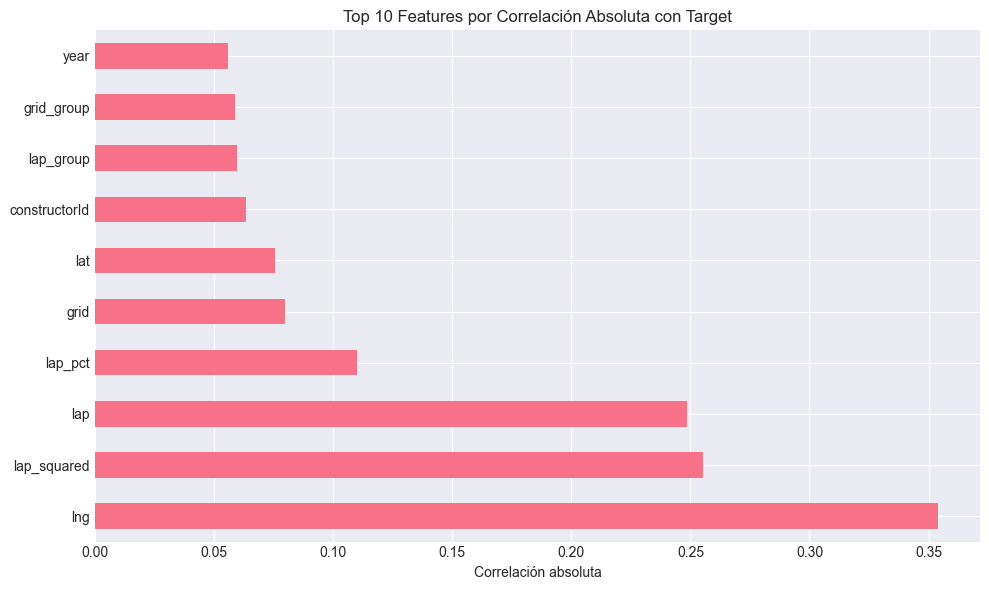

In [17]:
# Análisis de correlación con target
correlation_with_target = df_fe[features + [target_col]].corr()[target_col].sort_values(ascending=False)
print("Correlaciones con el target:")
print(correlation_with_target)

# Visualizar top correlaciones
top_corr = correlation_with_target.drop(target_col).abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_corr.plot(kind='barh')
plt.title('Top 10 Features por Correlación Absoluta con Target')
plt.xlabel('Correlación absoluta')
plt.tight_layout()
plt.show()

In [18]:
# Detección de multicolinealidad
feature_corr = df_fe[features].corr()
high_corr_pairs = []

for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.8:
            high_corr_pairs.append((feature_corr.columns[i],
                                   feature_corr.columns[j],
                                   feature_corr.iloc[i, j]))

if high_corr_pairs:
    print(f"\nPares de features con alta correlación (>0.8):")
    for f1, f2, corr in high_corr_pairs:
        print(f"  {f1} - {f2}: {corr:.3f}")
else:
    print("\nNo se detectaron pares con multicolinealidad alta (>0.8)")


Pares de features con alta correlación (>0.8):
  lap - lap_pct: 0.962
  lap - lap_squared: 0.961
  lap_pct - lap_squared: 0.895
  year - year_group: 0.842
  grid - grid_group: -0.817


In [19]:
# División train/test
from sklearn.model_selection import train_test_split

X = df_fe[features]
y = df_fe[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (456442, 14)
Conjunto de prueba: (114111, 14)


In [20]:
# Guardar datasets procesados
X_train.to_csv(DATA_CLEANED / "X_train.csv", index=False)
X_test.to_csv(DATA_CLEANED / "X_test.csv", index=False)
y_train.to_csv(DATA_CLEANED / "y_train.csv", index=False)
y_test.to_csv(DATA_CLEANED / "y_test.csv", index=False)

print("Datasets guardados:")
print(f"  {DATA_CLEANED / 'X_train.csv'}")
print(f"  {DATA_CLEANED / 'X_test.csv'}")
print(f"  {DATA_CLEANED / 'y_train.csv'}")
print(f"  {DATA_CLEANED / 'y_test.csv'}")

Datasets guardados:
  /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned/X_train.csv
  /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned/X_test.csv
  /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned/y_train.csv
  /home/luis-salamanca/Escritorio/Duoc/ML/F1_ML/data/cleaned/y_test.csv


## Conclusión

El procesamiento de datos ha finalizado exitosamente. Los datos están listos para modelado:

- Dataset limpio sin duplicados ni valores nulos críticos
- Outliers eliminados usando método IQR
- 8 features derivadas creadas
- Variables categóricas codificadas
- División train/test (80/20) realizada
- Datos guardados en `data/cleaned/`

**Próximo paso**: Proceder al notebook de modelado (02-ModelsRegression.ipynb)